In [1]:
import numpy as np
import pandas as pd
import time
from IPython.display import clear_output
from IPython import display
import matplotlib.pyplot as plt
#from numba import njit

In [52]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import optuna

In [3]:
testenv = np.array([[[0] * 5] * 4] * 3)
testenv[2,3,0] = 1
testenv[2,3,1] = 1
testenv[2,3,2] = 1
testenv[2,3,3] = 1
testenv[2,3,4] = 1
testenv[2,2,0] = 0

In [73]:
#Input: een keuze tussen bij 4 keuzes (bij 4x?x?)
#Output: Nieuwe environment


class Environment:
    def __init__(self, size, posreward = 2, negreward = -2):
        self.size = size
        self.environment = np.array([[[0] * self.size[2]] * self.size[1]] * self.size[0])
        self.posreward = posreward
        self.negreward = negreward
        self.action_space = self.environment.shape[1]
        self.observation_space = np.prod(size)
        self.input_space = size
        
    def resetField(self):
        self.environment = np.array([[[0] * self.size[2]] * self.size[1]] * self.size[0])
        
    def resetEnvironment(self):
        self.resetField()
        self.score = 0
        self.done = False
    
    def GenerateEnvironment(self):
        return np.array([[[0] * self.size[2]] * self.size[1]] * self.size[0])
        temp = np.array([[[0] * self.size[2]] * self.size[1]] * self.size[0])
        maxcont = self.size[0] * self.size[2]
        for i in range(self.size[1]):
            for o in range(np.random.randint(maxcont/2,maxcont)):
                actionPos = self.checkValidPositionInRow(temp,i)
                temp[actionPos] = 1
        return temp
    
    def genObs(self, env):
        
        return np.array(env, dtype=np.float32)
        #return np.array((env == 0).sum(axis=2), dtype=np.float32)
    
    def step(self, env, action):
        #actionspace = y
        
        
        #Save Old State
        newState = env.copy()
        
        actionPos = self.checkValidPositionInRow(env, action)
        #print(actionPos)
        done = False
        
        #Make move
        if self.placeContainer(actionPos, newState):
            #If move is allowed reward
            newState[actionPos] = 1
            reward = self.posreward
        else:
            #If move is not allowed punish
            reward = self.negreward
        
        #End game if field is all #s or if the user messed up.
        if np.all(newState != 0) or reward == self.negreward:
            done = True
            self.done = True
        return newState, reward, done
    
    def placeContainer(self, pos, env):
        if self.isLegal(pos, env):
            return True
        else:
            return False
        
    def isLegal(self, pos, env):
        IO = self.isOccupied(pos, env)
        IF = self.isFloating(pos, env)
        IIE = self.posIsInEnv(pos, env)
        NAS = self.hasNorthAndSouth(pos, env)
        #print(IO,IF,IIE,NAS)
        return not IO and not IF and IIE and not NAS
    
    def isOccupied(self, pos, env):
        if self.posIsInEnv(pos, env):
            return env[pos] != 0
        else:
            return False
    
    def hasNorthAndSouth(self, pos, env):
        NC = self.isOccupied((pos[0]-1,pos[1],0), env)
        SC = self.isOccupied((pos[0]+1,pos[1],0), env)
        #print(NC,SC)
        return NC and SC
    
    def posIsInEnv(self, pos, env):
        x = 0 <= pos[0] < env.shape[0]
        y = 0 <= pos[1] < env.shape[1]
        z = 0 <= pos[2] < env.shape[2]  
        return x and y and z
    
    def isFloating(self, pos, env):
        return np.any(env[pos[0],pos[1],:pos[2]] == 0)
    
    def checkValidPositionInRow(self, env, row):
        positions = np.dstack(np.where(env[row,:,:] == 0))
        if positions.size != 0:
            result = positions[positions[:,:,0] == np.max(positions[:,:,0])][0]
            
        else:
            result = (0,0)
        return row, result[0], result[1]


In [69]:
#UnitTests
Steps = [[0,2,2]]

for o in Steps:
    e = Environment(size=(3,3,2))
    environment = e.GenerateEnvironment()
    
    for i in o:
        environment, reward, done = e.step(environment,i)
        #print("Position: ", np.unravel_index(i, environment.shape), "\nEnvironment: ", environment.flatten(), "\nReward", reward)
    
    print("Test ",o," done\n",e.genObs(environment))
    print(e.input_space)


Test  [0, 2, 2]  done
 [[[0. 0.]
  [1. 1.]
  [1. 1.]]

 [[0. 0.]
  [1. 1.]
  [1. 1.]]

 [[1. 0.]
  [1. 1.]
  [1. 1.]]]
(3, 3, 2)


# Model

Agent(
    -Environment
    -CNN
    -Trainer)
    
    
    
# Pseudo pseudocode
<code>N = 10</code>

<code>While True:</code><br>
<code>    //Gaming moment (play 10 games)</code><br>
<code>    for i in range(10):</code><br>
<code>        pred = agent.pred()</code><br>
<code>        agent.rememberMoves()</code><br>
<code>    //Learning moment (train on previous games if possible)</code><br>
<code>    agent.trainNN()</code><br>



# Convolutional Neural Network

In [74]:
#Kernel ff aanpassen dat het niet 3x3 is maar bijv 3x1
#Environment aanpassen dat hij maar op de gewenste posities iets neer kan zetten.
#Environment aanpassen dat hij maar vanaf boven neer kan zetten.
class CNN(nn.Module):
    def __init__(self, lr, input_space, action_space, l2Dims=128):
        super().__init__()
        self.input_space = input_space
        self.action_space = action_space
        self.l2Dims = l2Dims
        self.layer1 = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size = (3,1,3), stride = 1, padding = (1,0,1)),
            #nn.Conv2d(1, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Linear(16*np.prod(self.input_space), self.l2Dims),
            nn.ReLU())
        #self.fc = nn.Linear(self.l2Dims, self.action_space)
        self.fc = nn.Linear(16*np.prod(self.input_space), self.action_space)
        
        self.loss = nn.MSELoss() # waarom hier een Lossfunctie definieren?
        # nn.CrossEntrophyLoss voor multiclassificatie problemen en een nn.BCELoss voor een enkelvoudig classificatieprobleem 
        self.optimizer = optim.Adam(self.parameters(),lr=lr)
        
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        
        # Alleen het model hoeft naar de device gezet te worden. 
        self.to(self.device)
        
    def forward(self, X):
        h = self.layer1(X)
        h = h.reshape(-1, 16*np.prod(self.input_space))
        #e = self.layer2(h)
        #y = self.fc(e)
        y = self.fc(h)
        
        return y

In [75]:
class Agent():
    def __init__(self, gamma, lr, batch_size, max_mem_size=100000, size = (3,3,2),epsilon = 0.99, eps_end=0.01, eps_dec=5e-4):
        
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        
        
        self.lr = lr
        self.gamma = gamma
        
        #Create Environment
        self.env = Environment(size)
        
        #self.action_space = self.env.action_space
        self.action_space = [i for i in range(self.env.action_space)]
        
        #Create Convolutional Neural Network
        self.cnn = CNN(lr = lr, input_space = self.env.input_space, action_space = self.env.action_space)
        
        #Memory variables
        self.mem_size = max_mem_size
        self.mem_cntr = 0
        self.batch_size = batch_size
        
        #Memory array variables
        self.state_memory = np.zeros((self.mem_size, 1, *self.env.input_space), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, 1, *self.env.input_space), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)
        
    def chooseAction(self, observation):
        if np.random.random() > self.epsilon:
            #Turn observation into tensor
            state = T.tensor([observation]).to(self.cnn.device)
            #Get action from neural network
            actions = self.cnn.forward(state)

            #Get maximum value and return index
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action
        
    def rememberMoves(self, state, action, reward, state_, done):
        #Makes counter loop over if max has been reached.
        index = self.mem_cntr % self.mem_size
        
        #Save specific variables to arrays
        self.state_memory[index] = [state]
        self.new_state_memory[index] = [state_]
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        
        #Increment memory counter
        self.mem_cntr += 1
        
    #TODO: We still need to add the trainer to this part.
    def trainNN(self):
        #If there's not enough memory for the batch size. Don't learn.
        if self.mem_cntr < self.batch_size:
            return
        
        self.cnn.optimizer.zero_grad()
        
        #Check what the maximum size is of the memory
        max_mem = min(self.mem_cntr, self.mem_size)
        
        #Choose a random batch
        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        
        #Get batch indices for the batch size. (aka an array of batch_size int32s)
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        
        #Load batch memory to device in tensors.
        state_batch = T.tensor(self.state_memory[batch]).to(self.cnn.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.cnn.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.cnn.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.cnn.device)
        
    
        
        #Load action batch memory.
        action_batch = self.action_memory[batch]
        
        #Generate output for eval state.
        q_eval = self.cnn.forward(state_batch)[batch_index, action_batch]
        
        #Generate output for next state.
        q_next = self.cnn.forward(new_state_batch)
        
        #Done state gets reset for the terminal batch?? idk?
        q_next[terminal_batch] = 0.0
        
        
        #Apply rewards to next batch.
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        
        loss = self.cnn.loss(q_target, q_eval).to(self.cnn.device)
        loss.backward()
        self.cnn.optimizer.step()
        
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
    
    

In [78]:
a = Agent(0.3, 0.001, 256, size=(3, 3, 3))
#env = a.env.GenerateEnvironment()

#Geen prioriteit: Randomly invullen en kijken wat ie doet :)
#Wel prioriteit: Randomly invullen en voeg score van de move toe.


RewardHistory = []
RewardHistoryHistory = []
#TOFIX: Check if memory is programmed right?
#TOFIX: Allow the training step to actually work.

done = False
for o in range(100000):
    
    for i in range(10):
        
        a.env.resetEnvironment()
        env = a.env.GenerateEnvironment()
        done = False
        while not done:
            obs = a.env.genObs(env)
            action = a.chooseAction(obs)
            newenv, reward, done = a.env.step(env,action)
            
            RewardHistory.append(reward)
            
            a.rememberMoves(a.env.genObs(env), action, reward, a.env.genObs(newenv), done)
            env = newenv

    a.trainNN()
    
    
    if o%10 == 0:
        clear_output(wait=True)
        print(o, np.mean(RewardHistory[-100:]))
        RewardHistoryHistory.append(np.mean(RewardHistory[-100:]))
        #clear_output(wait=True)
        #plt.plot(RewardHistoryHistory)
        #plt.show()

1680 1.76


KeyboardInterrupt: 

In [ ]:
def trial(trial):
    lr = trial.suggest_float('lr', 1e-1, 1e-4, log=True)
    
    # process of training model
    model = CNN(lr = lr, )
    t = Trainer()
    t.train
    
    return #score

study = optuna.create_study(direction = 'maximize')
study.optimize(trial, n_trials= 100, show_progress_bar=True)

In [ ]:
optuna.visualisation.plot_slice(study)

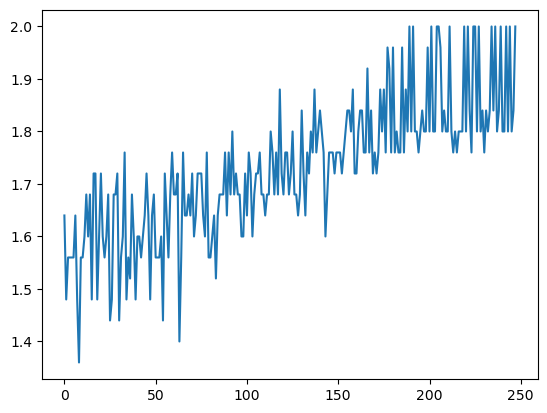

In [77]:
plt.plot(RewardHistoryHistory)
plt.show()